<H1>Predicting Flight Delays</H1>
<H3>by Michael Klear</H3>
Using <a href='http://stat-computing.org/dataexpo/2009/the-data.html'>this ASA dataset</a> of historic flights, I built a boosted regression model to estimate flight tardiness.<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


I use these functions to evaluate my model performance. I group delays into several different categories (details in docstring for function assign_delay_group).

In [2]:
def assign_delay_group(arrival_delay):
    '''Takes an arrival delay in minutes and returns a list of 
    group numbers. The groups correspond to the following encoding:
    == 0 if less than 30 minutes late (on time), 
    == 1 if 30-45 minutes late, 
    == 2 if 45-60 min late, 
    == 3 if 60-90, 
    == 4 if 90-120, 
    == 5 if 120-180,
    == 6 if 180-240,
    == 7 if more than 240
    '''
    d = int(arrival_delay)
    if d < 30:
        return 0
    if 30 <= d < 45:
        return 1
    if 45 <= d < 60:
        return 2
    if 60 <= d < 90:
        return 3
    if 90 <= d < 120:
        return 4
    if 120 <= d < 180:
        return 5
    if 180 <= d < 240:
        return 6
    if 240 <= d:
        return 7
    else:
        raise Exception('Error: unrecognized input')

def eval_performance(Y_, Y_true):
    """Takes a list of predicted arrival delays (Y_) and a matching list of actual
    arrival delays (Y_true) and evaluates them based on delay groups.
    """
    Y_ = list(pd.Series(Y_).apply(assign_delay_group))
    Y_true = list(pd.Series(Y_true).apply(assign_delay_group))
    results = pd.DataFrame()
    results['true_group'] = Y_true
    results['predicted_group'] = Y_
    results['correct'] = np.where(results.true_group == results.predicted_group, 1, 0)
    results['off_by'] = np.abs(results.true_group - results.predicted_group)
    results[results.correct==0].true_group.hist(bins=7);
    plt.title('True Arrival Groups of Misclassified Flights');
    plt.xlabel('True Arrival Group');
    plt.ylabel('Number of Misclassified Flights')
    plt.show();
    print('\n accuracy score: ', results.correct.sum()/len(results))
    results[results.correct==0].off_by.hist(bins=7);
    plt.title('"Off By" Numer of Groups for Misclassified Flights');
    plt.xlabel('Off By Number of Groups');
    plt.ylabel('Number of Misclassified Flights');
    plt.show();
    
    print('\n Portion of Predictions Off By More than One Group: ', (len(results[results.off_by >= 2])/len(results)))

I train my model on the month of April 2005 and test in on April 2006. I have modified the dataset to include latitude/longitude coordinates for each of the airports. I have also dropped diverted and cancelled flights.

In [3]:
apr05 = pd.read_csv('April05_cds.csv')
apr06 = pd.read_csv('April06_cds.csv')

In [4]:
apr05.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
       'org_latitude', 'org_longitude', 'dest_latitude', 'dest_longitude',
       'lat_dir', 'long_dir'],
      dtype='object')

In [5]:
delays = [
    'CarrierDelay',
    'WeatherDelay',
    'NASDelay',
    'SecurityDelay',
    'LateAircraftDelay'
]

#We can see the complex relationship between these delay type columns and total delay.
#I use a boosted decision tree model to help gather subtle information from these interactions.
apr05[apr05.DepDelay > 30][['DepDelay'] + delays].head()

,DepDelay,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
21,54.0,0,0,17,0,54
46,66.0,6,0,0,0,55
48,54.0,0,0,2,0,50
57,33.0,22,0,0,0,0
58,53.0,0,0,12,0,53


In [6]:
#These are all of our features
fts = delays + [
    'DayOfWeek',
    'DepTime',
    'Distance',
    'CRSElapsedTime',
    'DepDelay',
    'TaxiOut',
    'org_latitude',
    'org_longitude',
    'dest_latitude',
    'dest_longitude',
    'lat_dir',
    'long_dir'
]

X_train = pd.concat([apr05[fts], pd.get_dummies('UniqueCarrier')], axis=1)
X_test = pd.concat([apr06[fts], pd.get_dummies('UniqueCarrier')], axis=1)

<H2>Arrival Delay Varies from Departure Delay</H2><br>
One might think that arrival delay maps directly to departure delay. A simple model would be to simply predict that the arrival delay is equal to the departure delay. Let's see how this "null" model performs:

Null Model Performance (arrival delay = departure delay): All Flights April 2006 



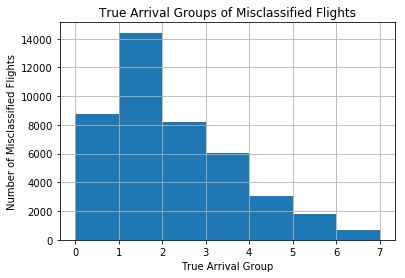


 accuracy score:  0.925496522525


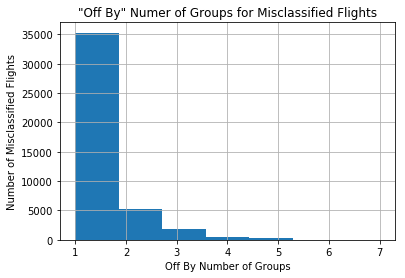


 Portion of Predictions Off By More than One Group:  0.013433889890915637


In [7]:
print('Null Model Performance (arrival delay = departure delay): All Flights April 2006 \n')
eval_performance(apr06.DepDelay, apr06.ArrDelay)

We can see that this model isn't terrible. It misclassifies roughly 7.5% of arrivals in terms of their actual delay groups.<br>
It does have some problems. More than 1% of all the predictions are off by more than one delay group, meaning that these predictions could cause problems for travelers or customer service agents relying on this model.

<H2>My Model: Break Flight Time into 3 Components</H2><br>
To improve on the "null model," I built several components into my prediction. The source of variance between departure delay and arrival delay is the difference between scheduled total flight time ("CRSElapsedTime") and the true flight time. This has three components: 1. TaxiOut (the time between departure and takeoff), 2. AirTime (the time from wheels up to touchdown), and 3. TaxiIn (the time between landing and arrival at gate.)<br>
Because the taxiout occurs immediately after departure, my model uses the true value for the first component. I then use two seperate xgboost models to predict flight time and taxi in time, and use the sum of these three components to predict the arrival time in my model.

In [8]:
#Put data into xgboost data matrices
dtrain_air = xgb.DMatrix(X_train, label=apr05['AirTime'])
dtest_air = xgb.DMatrix(X_test, label=apr06['AirTime'])

In [9]:
#Component 2: Predict Airtime
param = {
    'max_depth': 7, 
    'eta': .04, 
    'silent': 0, 
    'objective': 
    'reg:linear', 
    'alpha': 1,
    'lambda': 2,
    'nthread':4,
    'eval_metric':'rmse'
}

plst = param.items()
num_round = 635 #No additional gains after this point
evallist = [(dtest_air, 'eval'), (dtrain_air, 'train')]
air_est = xgb.train(plst, dtrain_air, num_round, evallist) 

[0]	eval-rmse:123.384	train-rmse:124.227
[1]	eval-rmse:118.787	train-rmse:119.674
[2]	eval-rmse:114.396	train-rmse:115.335
[3]	eval-rmse:110.195	train-rmse:111.158
[4]	eval-rmse:106.176	train-rmse:107.179
[5]	eval-rmse:102.341	train-rmse:103.378
[6]	eval-rmse:98.6616	train-rmse:99.6845
[7]	eval-rmse:95.158	train-rmse:96.2005
[8]	eval-rmse:91.7773	train-rmse:92.8262
[9]	eval-rmse:88.5795	train-rmse:89.6479
[10]	eval-rmse:85.5265	train-rmse:86.6136
[11]	eval-rmse:82.5796	train-rmse:83.6646
[12]	eval-rmse:79.7638	train-rmse:80.8515
[13]	eval-rmse:77.1128	train-rmse:78.1776
[14]	eval-rmse:74.5483	train-rmse:75.6132
[15]	eval-rmse:72.1125	train-rmse:73.125
[16]	eval-rmse:69.8074	train-rmse:70.801
[17]	eval-rmse:67.6049	train-rmse:68.5829
[18]	eval-rmse:65.479	train-rmse:66.4696
[19]	eval-rmse:63.4802	train-rmse:64.4278
[20]	eval-rmse:61.5711	train-rmse:62.4795
[21]	eval-rmse:59.774	train-rmse:60.624
[22]	eval-rmse:58.0385	train-rmse:58.8524
[23]	eval-rmse:56.4257	train-rmse:57.2007
[24]	eva

[194]	eval-rmse:28.2706	train-rmse:19.7483
[195]	eval-rmse:28.2612	train-rmse:19.7189
[196]	eval-rmse:28.2593	train-rmse:19.6739
[197]	eval-rmse:28.2547	train-rmse:19.6478
[198]	eval-rmse:28.2559	train-rmse:19.6367
[199]	eval-rmse:28.2483	train-rmse:19.6035
[200]	eval-rmse:28.2445	train-rmse:19.581
[201]	eval-rmse:28.2393	train-rmse:19.5647
[202]	eval-rmse:28.2338	train-rmse:19.5209
[203]	eval-rmse:28.2332	train-rmse:19.5091
[204]	eval-rmse:28.2269	train-rmse:19.4683
[205]	eval-rmse:28.2309	train-rmse:19.4379
[206]	eval-rmse:28.229	train-rmse:19.4052
[207]	eval-rmse:28.2278	train-rmse:19.3675
[208]	eval-rmse:28.2266	train-rmse:19.3551
[209]	eval-rmse:28.2246	train-rmse:19.2904
[210]	eval-rmse:28.2248	train-rmse:19.2802
[211]	eval-rmse:28.222	train-rmse:19.2649
[212]	eval-rmse:28.2199	train-rmse:19.2423
[213]	eval-rmse:28.2189	train-rmse:19.2175
[214]	eval-rmse:28.2184	train-rmse:19.1792
[215]	eval-rmse:28.2161	train-rmse:19.1688
[216]	eval-rmse:28.2056	train-rmse:19.1555
[217]	eval-rms

[386]	eval-rmse:27.9102	train-rmse:16.2476
[387]	eval-rmse:27.9122	train-rmse:16.2437
[388]	eval-rmse:27.9145	train-rmse:16.2315
[389]	eval-rmse:27.9139	train-rmse:16.2245
[390]	eval-rmse:27.9138	train-rmse:16.2194
[391]	eval-rmse:27.9191	train-rmse:16.2037
[392]	eval-rmse:27.9093	train-rmse:16.1815
[393]	eval-rmse:27.91	train-rmse:16.1751
[394]	eval-rmse:27.9091	train-rmse:16.1646
[395]	eval-rmse:27.9093	train-rmse:16.1609
[396]	eval-rmse:27.9033	train-rmse:16.1303
[397]	eval-rmse:27.9035	train-rmse:16.114
[398]	eval-rmse:27.9043	train-rmse:16.1081
[399]	eval-rmse:27.9044	train-rmse:16.0781
[400]	eval-rmse:27.9018	train-rmse:16.061
[401]	eval-rmse:27.9025	train-rmse:16.0551
[402]	eval-rmse:27.9031	train-rmse:16.0177
[403]	eval-rmse:27.9217	train-rmse:15.9951
[404]	eval-rmse:27.9209	train-rmse:15.989
[405]	eval-rmse:27.9212	train-rmse:15.9842
[406]	eval-rmse:27.9109	train-rmse:15.9343
[407]	eval-rmse:27.9096	train-rmse:15.9189
[408]	eval-rmse:27.9126	train-rmse:15.8872
[409]	eval-rmse:

[578]	eval-rmse:27.8401	train-rmse:13.8629
[579]	eval-rmse:27.8403	train-rmse:13.8563
[580]	eval-rmse:27.8405	train-rmse:13.8515
[581]	eval-rmse:27.8382	train-rmse:13.8452
[582]	eval-rmse:27.837	train-rmse:13.8356
[583]	eval-rmse:27.8384	train-rmse:13.8218
[584]	eval-rmse:27.8366	train-rmse:13.8136
[585]	eval-rmse:27.8379	train-rmse:13.7924
[586]	eval-rmse:27.8357	train-rmse:13.7842
[587]	eval-rmse:27.8359	train-rmse:13.783
[588]	eval-rmse:27.8348	train-rmse:13.7812
[589]	eval-rmse:27.8346	train-rmse:13.7801
[590]	eval-rmse:27.8356	train-rmse:13.76
[591]	eval-rmse:27.8371	train-rmse:13.7495
[592]	eval-rmse:27.8381	train-rmse:13.7471
[593]	eval-rmse:27.8372	train-rmse:13.7404
[594]	eval-rmse:27.8373	train-rmse:13.7337
[595]	eval-rmse:27.8376	train-rmse:13.7185
[596]	eval-rmse:27.8384	train-rmse:13.7157
[597]	eval-rmse:27.8405	train-rmse:13.7021
[598]	eval-rmse:27.8417	train-rmse:13.6993
[599]	eval-rmse:27.8422	train-rmse:13.6879
[600]	eval-rmse:27.8403	train-rmse:13.682
[601]	eval-rmse:

In [10]:
#Roughly estimate arrival time to help predict taxi in time.
apr05['est_act_arrtime'] = apr05.CRSArrTime + apr05.DepDelay
apr06['est_act_arrtime'] = apr06.CRSArrTime + apr06.DepDelay

In [11]:
#I reason that fewer factors influence taxi in time; I reduce features to include only destination location
# (scheduled) arrival time and day of week, as well as carrier (airline)
fts_tax = [
    'DayOfWeek',
    'est_act_arrtime',
    'dest_latitude',
    'dest_longitude'
]

Xtax_train = pd.concat([apr05[fts], pd.get_dummies('UniqueCarrier')], axis=1)
Xtax_test = pd.concat([apr06[fts], pd.get_dummies('UniqueCarrier')], axis=1)

In [12]:
dtrain_tax = xgb.DMatrix(Xtax_train, label=apr05['TaxiIn'])
dtest_tax = xgb.DMatrix(Xtax_test, label=apr06['TaxiIn'])

param = {
    'max_depth': 4, 
    'eta': .04, 
    'silent': 0, 
    'objective': 
    'reg:linear', 
    #'alpha': 1,
    #'lambda': 2,
    'nthread':4,
    'eval_metric':'rmse'
}

plst = param.items()
num_round = 700
evallist = [(dtest_tax, 'eval'), (dtrain_tax, 'train')]
tax_est = xgb.train(plst, dtrain_tax, num_round, evallist)

[0]	eval-rmse:32.8663	train-rmse:43.733
[1]	eval-rmse:32.6143	train-rmse:43.2007
[2]	eval-rmse:32.3893	train-rmse:42.6636
[3]	eval-rmse:32.1242	train-rmse:42.1914
[4]	eval-rmse:31.9262	train-rmse:41.7506
[5]	eval-rmse:31.7026	train-rmse:41.3232
[6]	eval-rmse:31.4982	train-rmse:40.9251
[7]	eval-rmse:31.3104	train-rmse:40.5545
[8]	eval-rmse:31.1395	train-rmse:40.2096
[9]	eval-rmse:30.9814	train-rmse:39.888
[10]	eval-rmse:30.849	train-rmse:39.5889
[11]	eval-rmse:30.6926	train-rmse:39.2896
[12]	eval-rmse:30.5663	train-rmse:39.0247
[13]	eval-rmse:30.4762	train-rmse:38.7663
[14]	eval-rmse:30.3949	train-rmse:38.5302
[15]	eval-rmse:30.2924	train-rmse:38.3152
[16]	eval-rmse:30.2272	train-rmse:38.1042
[17]	eval-rmse:30.1482	train-rmse:37.9145
[18]	eval-rmse:30.0927	train-rmse:37.6499
[19]	eval-rmse:30.0044	train-rmse:37.4832
[20]	eval-rmse:29.9325	train-rmse:37.3152
[21]	eval-rmse:29.8924	train-rmse:37.1609
[22]	eval-rmse:29.8204	train-rmse:37.0214
[23]	eval-rmse:29.7644	train-rmse:36.8813
[24]	

[194]	eval-rmse:28.6826	train-rmse:29.3481
[195]	eval-rmse:28.6911	train-rmse:29.3346
[196]	eval-rmse:28.7137	train-rmse:29.3113
[197]	eval-rmse:28.7205	train-rmse:29.3052
[198]	eval-rmse:28.6949	train-rmse:29.2323
[199]	eval-rmse:28.6801	train-rmse:29.2182
[200]	eval-rmse:28.68	train-rmse:29.2132
[201]	eval-rmse:28.6776	train-rmse:29.2069
[202]	eval-rmse:28.6776	train-rmse:29.2022
[203]	eval-rmse:28.6804	train-rmse:29.1884
[204]	eval-rmse:28.684	train-rmse:29.1701
[205]	eval-rmse:28.6909	train-rmse:29.1645
[206]	eval-rmse:28.6837	train-rmse:29.1274
[207]	eval-rmse:28.6479	train-rmse:29.08
[208]	eval-rmse:28.6526	train-rmse:29.0758
[209]	eval-rmse:28.6464	train-rmse:29.0471
[210]	eval-rmse:28.6515	train-rmse:29.0422
[211]	eval-rmse:28.6471	train-rmse:29.0353
[212]	eval-rmse:28.6472	train-rmse:29.0309
[213]	eval-rmse:28.6545	train-rmse:29.0263
[214]	eval-rmse:28.6558	train-rmse:29.0027
[215]	eval-rmse:28.6253	train-rmse:28.9595
[216]	eval-rmse:28.6306	train-rmse:28.9552
[217]	eval-rmse:

[386]	eval-rmse:28.4742	train-rmse:26.2105
[387]	eval-rmse:28.4735	train-rmse:26.2076
[388]	eval-rmse:28.4694	train-rmse:26.2047
[389]	eval-rmse:28.471	train-rmse:26.2034
[390]	eval-rmse:28.4649	train-rmse:26.1487
[391]	eval-rmse:28.4603	train-rmse:26.1383
[392]	eval-rmse:28.4588	train-rmse:26.1275
[393]	eval-rmse:28.4593	train-rmse:26.1178
[394]	eval-rmse:28.4575	train-rmse:26.1083
[395]	eval-rmse:28.4591	train-rmse:26.1045
[396]	eval-rmse:28.4608	train-rmse:26.099
[397]	eval-rmse:28.4471	train-rmse:26.0388
[398]	eval-rmse:28.4428	train-rmse:26.0286
[399]	eval-rmse:28.4424	train-rmse:26.0265
[400]	eval-rmse:28.4358	train-rmse:25.9959
[401]	eval-rmse:28.449	train-rmse:25.9882
[402]	eval-rmse:28.4492	train-rmse:25.9855
[403]	eval-rmse:28.4484	train-rmse:25.9835
[404]	eval-rmse:28.4484	train-rmse:25.9818
[405]	eval-rmse:28.4336	train-rmse:25.9493
[406]	eval-rmse:28.4354	train-rmse:25.9441
[407]	eval-rmse:28.4494	train-rmse:25.9293
[408]	eval-rmse:28.4455	train-rmse:25.9044
[409]	eval-rms

[578]	eval-rmse:28.2446	train-rmse:23.9531
[579]	eval-rmse:28.2465	train-rmse:23.9455
[580]	eval-rmse:28.2428	train-rmse:23.9377
[581]	eval-rmse:28.2426	train-rmse:23.9359
[582]	eval-rmse:28.2367	train-rmse:23.9281
[583]	eval-rmse:28.2418	train-rmse:23.9011
[584]	eval-rmse:28.2393	train-rmse:23.8933
[585]	eval-rmse:28.2373	train-rmse:23.878
[586]	eval-rmse:28.2381	train-rmse:23.874
[587]	eval-rmse:28.2328	train-rmse:23.849
[588]	eval-rmse:28.23	train-rmse:23.845
[589]	eval-rmse:28.2413	train-rmse:23.8182
[590]	eval-rmse:28.2425	train-rmse:23.8024
[591]	eval-rmse:28.2412	train-rmse:23.8011
[592]	eval-rmse:28.1969	train-rmse:23.7493
[593]	eval-rmse:28.1975	train-rmse:23.748
[594]	eval-rmse:28.1996	train-rmse:23.7419
[595]	eval-rmse:28.2005	train-rmse:23.7381
[596]	eval-rmse:28.2018	train-rmse:23.7318
[597]	eval-rmse:28.1961	train-rmse:23.7123
[598]	eval-rmse:28.1957	train-rmse:23.6956
[599]	eval-rmse:28.1968	train-rmse:23.6881
[600]	eval-rmse:28.2014	train-rmse:23.661
[601]	eval-rmse:28.

Finally, I put my models (trained on April 2005 data) to use and make some predictionson the April 2006 arrival times.

Three-Component Predictions with Boosted Decision Trees Performance: All Flights April 2006 



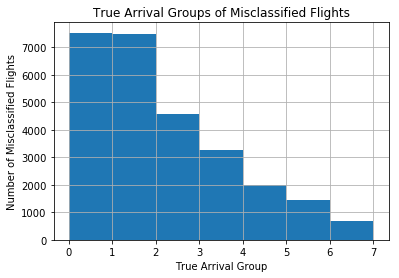


 accuracy score:  0.953302476295


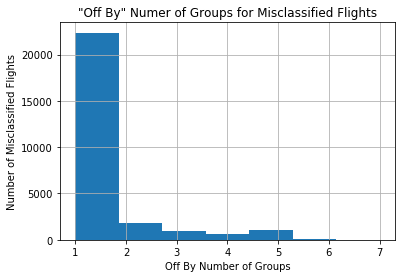


 Portion of Predictions Off By More than One Group:  0.007993519329499859


In [13]:
est_elapsed_time = apr06.TaxiOut + air_est.predict(dtest_air) + tax_est.predict(dtest_tax)
preds = apr06.DepDelay + est_elapsed_time - apr06.CRSElapsedTime
print('Three-Component Predictions with Boosted Decision Trees Performance: All Flights April 2006 \n')
eval_performance(preds, apr06.ArrDelay)

<H3>Evaluation</H3><br>
My three-component model eliminated more than one-third of the misplaced arrival groups. It also reduced the number of predicted arrival times off by more than one group to less than .8% of all predictions.<br>
This shows that my approach works, but there is still alot of room for improvement. Honestly, I spent most of my time tuning up the airtime component and the taxi in time estimation is pretty lousy. With more work, I think I can improve the taxi in time estimation and greatly improve the overall performance of my model.